In [1]:
# Importing required libraries
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')
# Importing store data
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

/home/gavril/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train = pd.read_csv('rto.csv',delimiter=';')
train.head()
train['Sales'] = train['Sales'] * 100000.0

In [3]:
 train.ShopID.unique().shape

(626,)

In [4]:
train['date'] = pd.to_datetime(train.Period,format='%d.%m.%Y')

In [5]:
train=train.sort_values(by='date')

In [6]:
# Посмотрим пока нра одине магазин
train_df = train[train['ShopID']==2]

In [7]:
train_df['year'] = train['date'].dt.year
train_df['month'] = train['date'].dt.month

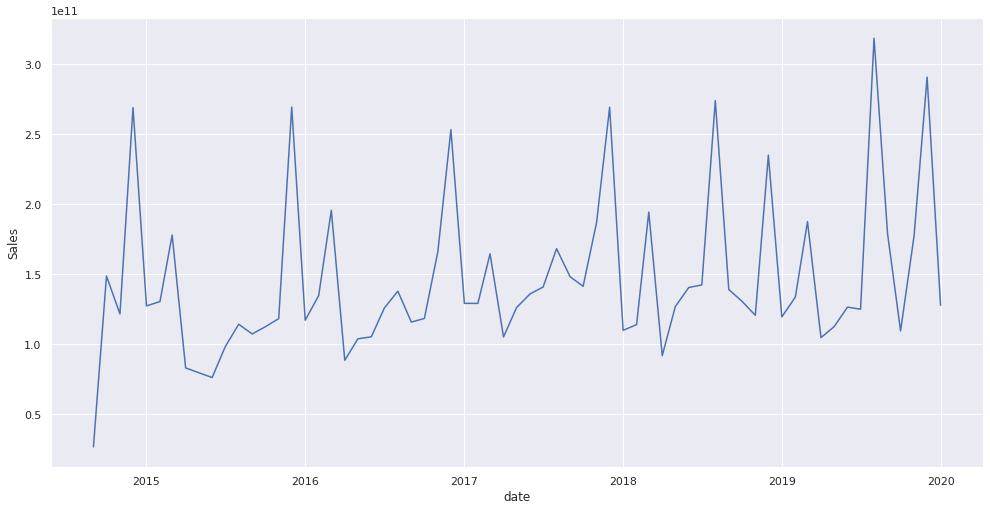

In [8]:

color = sns.color_palette()
sns.set(rc={'figure.figsize':(16.7,8.27)})

sns.set_style('darkgrid')

sns.lineplot(x="date", y="Sales",legend = 'full' , data=train_df)

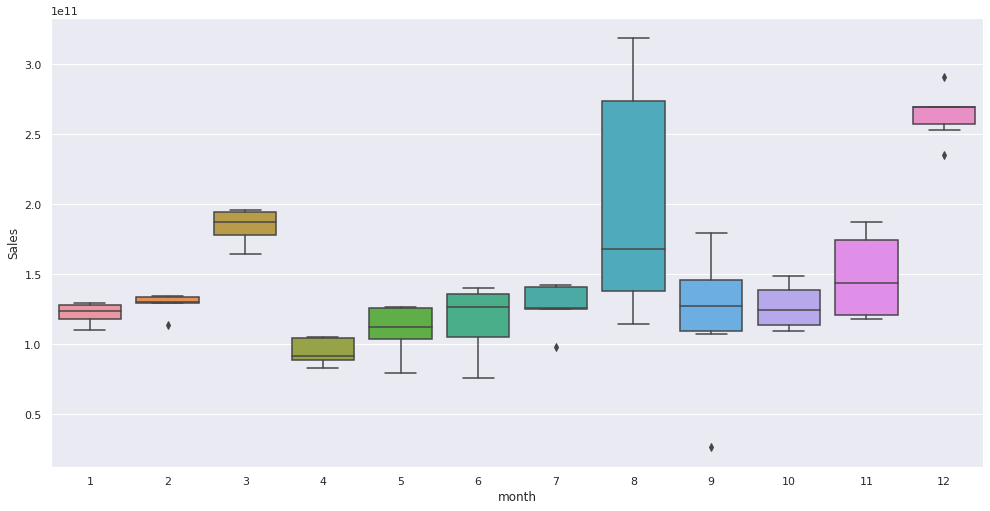

In [9]:
sns.boxplot(x="month", y="Sales", data=train_df)

#### Очевидно, есть какая-то сезонность, Продажи растут в конце и середине года, ну и тренд какой-то заметен

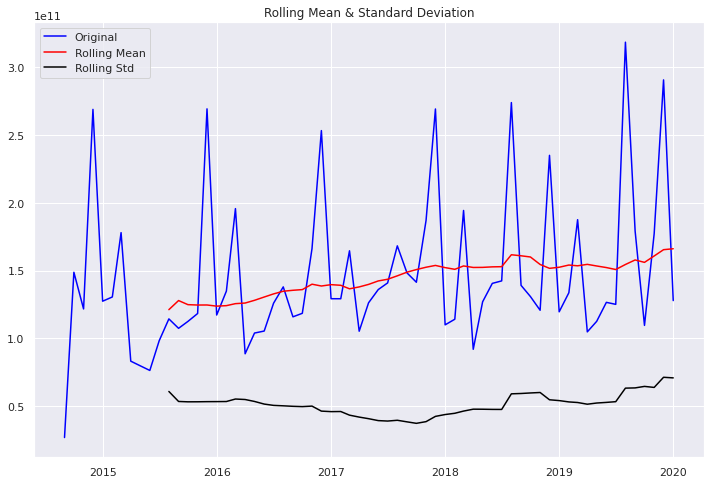

Results of Dickey-Fuller Test:
p-value = 0.8349. The series is likely non-stationary.
Test Statistic                 -0.744565
p-value                         0.834866
#Lags Used                     11.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


In [10]:
train_df = train_df.set_index('date')
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 12 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
test_stationarity(train_df['Sales'])

#### Ряд нестационарен

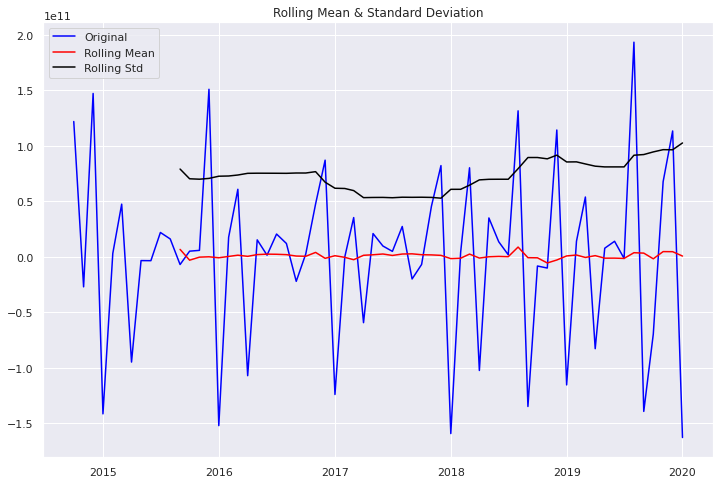

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.212708e+01
p-value                        1.770503e-22
#Lags Used                     1.000000e+01
Number of Observations Used    5.300000e+01
Critical Value (1%)           -3.560242e+00
Critical Value (5%)           -2.917850e+00
Critical Value (10%)          -2.596796e+00
dtype: float64


In [11]:
first_diff = train_df.Sales - train_df.Sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

#### Хотя при пререходе к первым разницам- стационаризуется


### Я попробовал, разное ARIMA, SARIMA, Prophet.как тут:
* https://www.kaggle.com/poiupoiu/how-to-use-sarimax   
###  Но они при генерализации на 600 рядов дают результат хуже, чем сетка. Сейчас нет сил-времени показывать

## Не знаешь, что делать- обучай сетку

In [40]:
train = pd.read_csv('rto.csv',delimiter=';',parse_dates=True)

train['Sales'] = train['Sales'] / 1000000.0

In [41]:
train.head()

,Period,ShopID,RegionID,CityID,Sales
0,01.07.2017,1,1,1,0.666366
1,01.06.2016,2,2,2,1.053634
2,01.12.2018,3,3,3,3.373644
3,01.05.2018,4,4,4,2.065336
4,01.02.2020,5,5,5,2.105369


In [42]:
train['date'] = pd.to_datetime(train.Period,format='%d.%m.%Y')

In [43]:
train= train.set_index(train.date)

In [44]:
train_data=train.copy()

In [45]:
train_data.drop('date', 1, inplace=True)
train_data.drop('Period', 1, inplace=True)

In [46]:
min_year=train_data.index.year.min()

In [47]:
train_data['y'] = train_data.index.year-min_year
train_data['m'] = train_data.index.month

In [48]:
train_data

,ShopID,RegionID,CityID,Sales,y,m
date,,,,,,
2017-07-01,1,1,1,0.666366,5,7
2016-06-01,2,2,2,1.053634,4,6
2018-12-01,3,3,3,3.373644,6,12
2018-05-01,4,4,4,2.065336,6,5
2020-02-01,5,5,5,2.105369,8,2
...,...,...,...,...,...,...
2016-02-01,413,80,54,1.032833,4,2
2018-01-01,155,38,28,0.665122,6,1
2017-02-01,338,67,45,1.059181,5,2


### Возьмем для валидации последний год

In [49]:
test_date=train_data.index.sort_values().unique()[-12:]

In [50]:
test_data=train_data[train_data.index.isin(test_date)]

In [51]:
train_data=train_data[~train_data.index.isin(test_date)]

In [52]:
y_train = train_data.iloc[:,3].values
y_test= test_data.iloc[:,3].values

In [53]:
y_train_full=y_train.copy()

In [54]:
train_data.drop('Sales', 1, inplace=True)
test_data.drop('Sales', 1, inplace=True)

In [55]:
### Разделмим на тест-трейн, проведм предобработку

In [56]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_data, y_train, test_size=.1, random_state=0, shuffle = True)

In [57]:
x_train

,ShopID,RegionID,CityID,y,m
date,,,,,
2017-01-01,188,98,59,5,1
2016-11-01,141,1,1,4,11
2015-05-01,101,17,14,3,5
2016-04-01,57,8,4,4,4
2013-12-01,253,8,4,1,12
...,...,...,...,...,...
2014-10-01,179,2,2,2,10
2012-06-01,229,8,4,0,6
2019-01-01,278,8,4,7,1


In [58]:
train_data.columns

Index(['ShopID', 'RegionID', 'CityID', 'y', 'm'], dtype='object')

In [59]:
# у нас только год число, остлаьные признаки-категориальные
cat_vars = list(train_data.columns)
cat_vars.remove('y')
cont_vars = ['y']

In [60]:
X_train = []
X_val = []
X_train.append(x_train[cont_vars].astype('float32').values)
X_val.append(x_val[cont_vars].astype('float32').values)
for cat in cat_vars:
    X_train.append(x_train[cat].values)
    X_val.append(x_val[cat].values)

In [61]:
cat_sizes = {}
cat_embsizes = {}
for cat in cat_vars:
    cat_sizes[cat] = train_data[cat].nunique()+100
    cat_embsizes[cat] = min(50, cat_sizes[cat]//2+1)

In [62]:
cat_sizes

{'ShopID': 660, 'RegionID': 269, 'CityID': 169, 'm': 112}

In [63]:
cat_embsizes

{'ShopID': 50, 'RegionID': 50, 'CityID': 50, 'm': 50}

In [64]:
from keras.layers import Dense, Activation, Reshape, merge, Embedding, Input, Concatenate,Dropout
from keras.models import Model 
import keras.backend as K
def custom_smape(x, x_):
    return K.mean(2*K.abs(x-x_)/(K.abs(x)+K.abs(x_)))

In [121]:
## Накидаем какую-нибудь простенеькую архитертуру
y = Input((len(cont_vars),), name='cont_vars')
ins = [y]
concat = [y]
for cat in cat_vars:
    x = Input((1,), name=cat)
    ins.append(x)
    x = Embedding(cat_sizes[cat]+1, cat_embsizes[cat], input_length=1)(x)
    x = Reshape((cat_embsizes[cat],))(x)
    concat.append(x)
y = Concatenate()(concat)
y = Dense(200, activation= 'relu')(y)
y = Dense(50, activation= 'relu')(y)
y=Dropout(.2)(y)
y = Dense(20, activation= 'relu')(y)
y=Dropout(.2)(y)
y = Dense(1)(y)
model = Model(ins, y)
model.summary()
model.compile('adadelta', custom_smape)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ShopID (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
RegionID (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
CityID (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
m (InputLayer)                  (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_

In [122]:
# Обучим ее
model.fit(X_train, y_train, 1024, 100, validation_data=[X_val, y_val])

Train on 15952 samples, validate on 1773 samples
Epoch 1/100
15952/15952 [==============================] - 1s 38us/step - loss: 0.9175 - val_loss: 0.5383
Epoch 2/100
15952/15952 [==============================] - 0s 7us/step - loss: 0.5701 - val_loss: 0.4978
Epoch 3/100
15952/15952 [==============================] - 0s 7us/step - loss: 0.5253 - val_loss: 0.4540
Epoch 4/100
15952/15952 [==============================] - 0s 7us/step - loss: 0.4857 - val_loss: 0.4123
Epoch 5/100
15952/15952 [==============================] - 0s 7us/step - loss: 0.4577 - val_loss: 0.4169
Epoch 6/100
15952/15952 [==============================] - 0s 7us/step - loss: 0.4418 - val_loss: 0.3794
Epoch 7/100
15952/15952 [==============================] - 0s 7us/step - loss: 0.4298 - val_loss: 0.3615
Epoch 8/100
15952/15952 [==============================] - 0s 7us/step - loss: 0.4163 - val_loss: 0.3495
Epoch 9/100
15952/15952 [==============================] - 0s 6us/step - loss: 0.3990 - val_loss: 0.3366
Epoch

Epoch 78/100
15952/15952 [==============================] - 0s 7us/step - loss: 0.2220 - val_loss: 0.1987
Epoch 79/100
15952/15952 [==============================] - 0s 7us/step - loss: 0.2221 - val_loss: 0.2079
Epoch 80/100
15952/15952 [==============================] - 0s 7us/step - loss: 0.2284 - val_loss: 0.1985
Epoch 81/100
15952/15952 [==============================] - 0s 7us/step - loss: 0.2236 - val_loss: 0.1894
Epoch 82/100
15952/15952 [==============================] - 0s 7us/step - loss: 0.2211 - val_loss: 0.1827
Epoch 83/100
15952/15952 [==============================] - 0s 7us/step - loss: 0.2201 - val_loss: 0.1830
Epoch 84/100
15952/15952 [==============================] - 0s 7us/step - loss: 0.2187 - val_loss: 0.1854
Epoch 85/100
15952/15952 [==============================] - 0s 7us/step - loss: 0.2161 - val_loss: 0.2081
Epoch 86/100
15952/15952 [==============================] - 0s 7us/step - loss: 0.2221 - val_loss: 0.1797
Epoch 87/100
15952/15952 [====================

### Сделаем предсказания на валидационном сете

In [123]:
X_test = []
X_test.append(test_data[cont_vars].astype('float32').values)
for cat in cat_vars:
    X_test.append(test_data[cat].values)
    

In [124]:
y_test_pred=model.predict(X_test)

In [125]:
y_test_pred

array([[1.7534498],
       [3.6010103],
       [2.2171702],
       ...,
       [8.718804 ],
       [2.8728995],
       [3.8373737]], dtype=float32)

In [126]:
y_test

array([ 2.105369,  5.624801,  1.867356, ..., 10.466957,  3.942286,
        4.037571])

In [129]:
b=test_data.copy()

In [130]:
b['y_test']=y_test

In [131]:
b['y_test_pred']=y_test_pred

In [133]:
c=b[['y_test','y_test_pred']].groupby(['date']).sum()

In [135]:
c

,y_test,y_test_pred
date,,
2019-04-01,831.283378,775.070618
2019-05-01,907.519228,905.301270
2019-06-01,1028.535678,991.131958
2019-07-01,1107.793179,1050.546021
2019-08-01,2466.471925,1601.676270
2019-09-01,1742.068511,1065.906372
2019-10-01,1088.481291,1044.515015
2019-11-01,1129.905521,1258.645142
2019-12-01,2288.231047,2123.631348


In [136]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

## Вот какие метрики получились

In [137]:
smape_kun(c.y_test,c.y_test_pred)

MAPE: 11.60 % 
SMAPE: 13.01 %


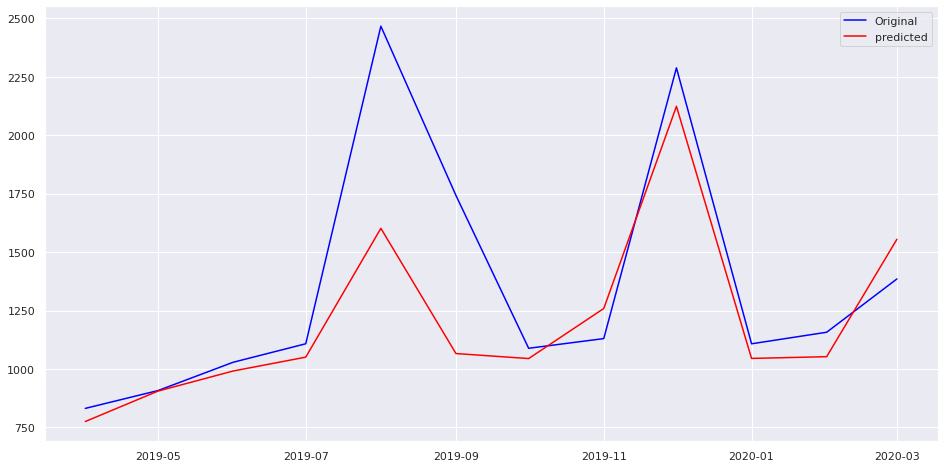

In [138]:
fig = plt.figure(figsize=(16, 8))
plt.plot(c.y_test, color='blue',label='Original')
plt.plot(c.y_test_pred, color='red',label='predicted')
plt.legend(loc='best')

## Сделаем прогноз на будущее

In [ ]:
# Возьмем магазины из последнегно месяца

In [142]:
test_data.index.unique().sort_values()

DatetimeIndex(['2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
               '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
               '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01'],
              dtype='datetime64[ns]', name='date', freq=None)

In [143]:
test_data.index.unique().sort_values()[-1]

Timestamp('2020-03-01 00:00:00')

In [144]:
shops =test_data[test_data.index==test_data.index.unique().sort_values()[-1]].drop_duplicates().reset_index()[['ShopID','RegionID','CityID']]

In [145]:
# Возьмем даты которые хотим предсказать

In [146]:
from datetime import timedelta 
dates =pd.DataFrame(test_data.index.unique().sort_values()[:-3]+ timedelta(days=366) )

In [147]:
### Декатово умножим одно на другое, чтобы получить призанки для сетки

In [148]:
def cartesian_product_basic(left, right):
    return (
       left.assign(key=1).merge(right.assign(key=1), on='key').drop('key', 1))

In [162]:
X_to_predict=cartesian_product_basic(shops,dates)

In [163]:
## Предобработаем и сделаем прогноз

In [164]:
X_to_predict =X_to_predict.set_index(X_to_predict.date)


In [165]:
X_to_predict['y'] = X_to_predict.index.year-min_year
X_to_predict['m'] = X_to_predict.index.month

In [166]:
X_to_predict

,ShopID,RegionID,CityID,date,y,m
date,,,,,,
2020-04-01,60,36,4,2020-04-01,8,4
2020-05-01,60,36,4,2020-05-01,8,5
2020-06-01,60,36,4,2020-06-01,8,6
2020-07-01,60,36,4,2020-07-01,8,7
2020-08-01,60,36,4,2020-08-01,8,8
...,...,...,...,...,...,...
2020-08-01,536,54,38,2020-08-01,8,8
2020-09-01,536,54,38,2020-09-01,8,9
2020-10-01,536,54,38,2020-10-01,8,10


In [167]:
X_to_predict.drop('date', 1, inplace=True)

In [168]:
x_to_predict = []

x_to_predict.append(X_to_predict[cont_vars].astype('float32').values)

for cat in cat_vars:
    x_to_predict .append(X_to_predict[cat].values)
    

In [169]:
# Сделаем проноз
y_to_predict=model.predict(x_to_predict)

In [170]:
X_to_predict['y_to_predict']=y_to_predict

In [171]:
X_to_predict.head()

,ShopID,RegionID,CityID,y,m,y_to_predict
date,,,,,,
2020-04-01,60,36,4,8,4,0.922908
2020-05-01,60,36,4,8,5,1.101429
2020-06-01,60,36,4,8,6,1.180203
2020-07-01,60,36,4,8,7,1.233959
2020-08-01,60,36,4,8,8,2.462669


In [175]:
X_to_predict.drop('y', 1, inplace=True)
X_to_predict.drop('m', 1, inplace=True)

In [176]:
#Сохраним его
X_to_predict.to_csv('predict.csv')

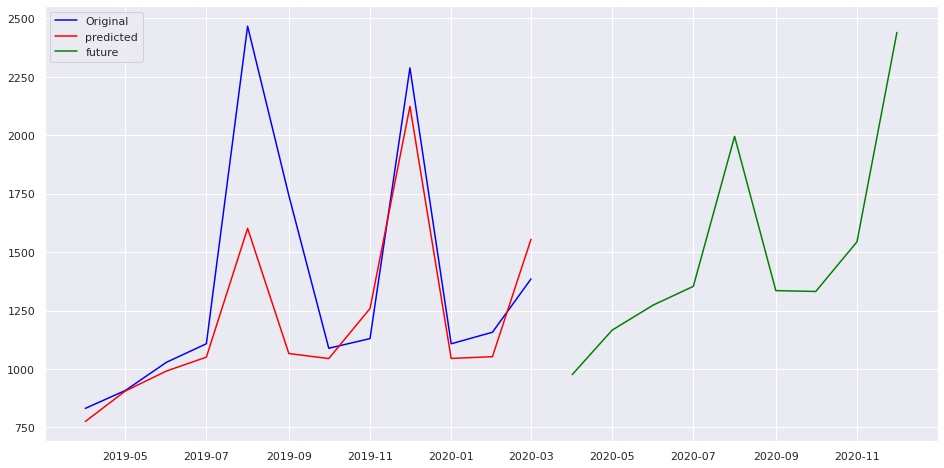

In [174]:
fig = plt.figure(figsize=(16, 8))
plt.plot(c.y_test, color='blue',label='Original')
plt.plot(c.y_test_pred, color='red',label='predicted')
plt.plot(X_to_predict.y_to_predict.groupby(['date']).sum(),color='green',label='future')
plt.legend(loc='best')